# Demo of SCOD on MNIST

In [4]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, KMNIST, EMNIST
from torch.utils.data import Subset

import seaborn as sns
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mnist = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
dataset = Subset(mnist, np.random.choice(len(mnist), 5000))

In [6]:
val_dataset =  MNIST(root="~/data/",train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
fashion_dataset = FashionMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
kmnist_dataset = KMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
emnist_dataset = EMNIST(root="~/data/",train=True,split="letters",download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

reg_dataset = torch.utils.data.ConcatDataset([val_dataset, fashion_dataset])

26422272it [00:02, 9915831.48it/s]                               


Extracting /Users/apoorva/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/apoorva/data/FashionMNIST/raw



29696it [00:00, 245797.21it/s]                          


Extracting /Users/apoorva/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/apoorva/data/FashionMNIST/raw



4422656it [00:01, 4180278.23it/s]                             


Extracting /Users/apoorva/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/apoorva/data/FashionMNIST/raw



6144it [00:00, 6723142.13it/s]          


Extracting /Users/apoorva/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/apoorva/data/FashionMNIST/raw



18165760it [00:49, 366195.34it/s]                              


Extracting /Users/apoorva/data/KMNIST/raw/train-images-idx3-ubyte.gz to /Users/apoorva/data/KMNIST/raw



29696it [00:00, 151208.66it/s]                          


Extracting /Users/apoorva/data/KMNIST/raw/train-labels-idx1-ubyte.gz to /Users/apoorva/data/KMNIST/raw



3041280it [00:10, 296175.56it/s]                             


Extracting /Users/apoorva/data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/apoorva/data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 8368993.17it/s]


Extracting /Users/apoorva/data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/apoorva/data/KMNIST/raw



561754112it [10:19, 907322.71it/s]                                


Extracting /Users/apoorva/data/EMNIST/raw/gzip.zip to /Users/apoorva/data/EMNIST/raw


In [10]:
# DNN mapping 2d input to 1d distribution parameter
# LeNet v5
model = nn.Sequential(
        nn.Conv2d(1, 6, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

dist_layer = scod.distributions.CategoricalLogitLayer()

In [12]:
device=torch.device('cpu')
model = model.to(device)

mean_loss=0.002960,lr=0.000000: 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


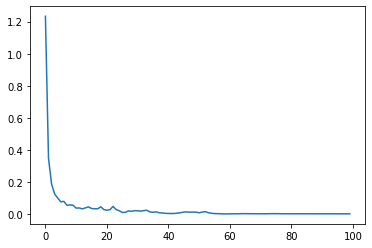

In [13]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs.to(device))
        dist = dist_layer(outputs)
        loss = -dist.log_prob(targets.to(device))

        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 2e3

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f,lr=%02f"%(epoch_loss.item(),scheduler.get_last_lr()[0]))
    losses.append(epoch_loss.item())

plt.plot(losses)

In [14]:
unc_model = scod.SCOD(model, args={
    'num_eigs': 100,
    'num_samples': 304,
    'sketch_type': 'srft',
})

Weight space dimension: 4.443e+04


### process training dataset to compute posterior uncertainty

In [15]:
unc_model.process_dataset(dataset, dist_layer)

computing basis
using T = 304


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/apoorva/code/scod-module/venv/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 5000/5000 [02:39<00:00, 31.25it/s]


### compare SCOD's predictions to the original trained model

In [18]:
settings = [
    {
        'name': 'Naive',
        'oodsignal': lambda x: dist_layer(model(x)).entropy()
    },
    {
        'name': 'SCOD-Entropy',
        'oodsignal': scod.OodDetector(unc_model, dist_layer, "entropy")
    },
    {
        'name': 'SCOD-KLDiv',
        'oodsignal': scod.OodDetector(unc_model, dist_layer, "local_kl")
    },
    {
        'name': 'SCOD-Var',
        'oodsignal': scod.OodDetector(unc_model, dist_layer, "var")
    }
]

In [19]:
from torch.utils.data import DataLoader
from tqdm import tqdm

dl_kwargs = {
    'batch_size': 25,
    'shuffle': False,
    'num_workers': 2,
}

val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 500))
fashion_subset = Subset(fashion_dataset, np.random.choice(len(fashion_dataset), 500))
kmnist_subset = Subset(kmnist_dataset, np.random.choice(len(kmnist_dataset), 500))
emnist_subset = Subset(emnist_dataset, np.random.choice(len(emnist_dataset), 500))

val_loader = DataLoader(val_subset, **dl_kwargs)
fashion_loader = DataLoader(fashion_subset, **dl_kwargs)
kmnist_loader = DataLoader(kmnist_subset, **dl_kwargs)
emnist_loader = DataLoader(emnist_subset, **dl_kwargs)

In [23]:
results = []
for setting in settings:
    detector = setting['oodsignal']
    val_uncs = torch.cat( [detector(batch[0].to(device)).detach().cpu() for batch in tqdm(val_loader)] )
    fashion_uncs = torch.cat( [detector(batch[0].to(device)).detach().cpu() for batch in tqdm(fashion_loader)] )
    kmnist_uncs = torch.cat( [detector(batch[0].to(device)).detach().cpu() for batch in tqdm(kmnist_loader)] )
    emnist_uncs = torch.cat( [detector(batch[0].to(device)).detach().cpu() for batch in tqdm(emnist_loader)] )

    result = {
        'name': setting['name'],
        'val': val_uncs,
        'fashion': fashion_uncs,
        'kmnist': kmnist_uncs,
        'emnist': emnist_uncs,
    }
    results.append(result)

100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


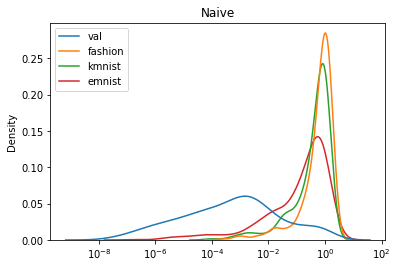

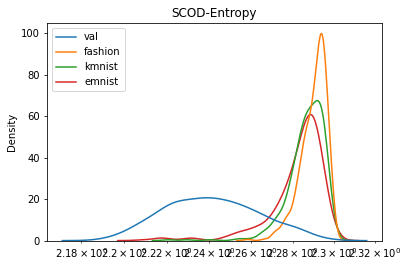

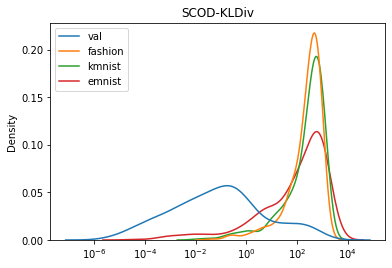

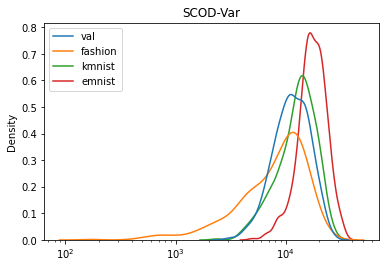

In [24]:
for result in results:
    plt.figure()
    sns.kdeplot(data = {
        'val': result['val'],
        'fashion': result['fashion'], 
        'kmnist': result['kmnist'],
        'emnist': result['emnist']
    }, cumulative=False, fill=False, log_scale=True )
    plt.title(result['name'])
    plt.show()

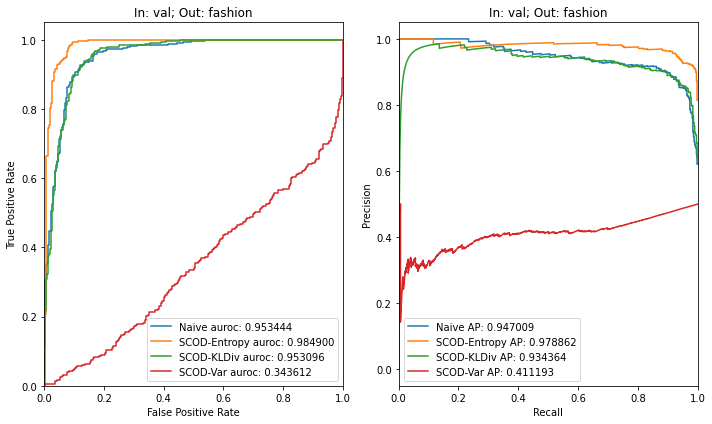

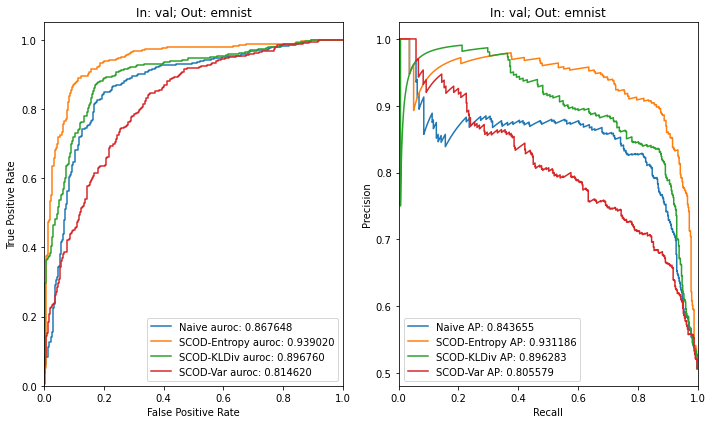

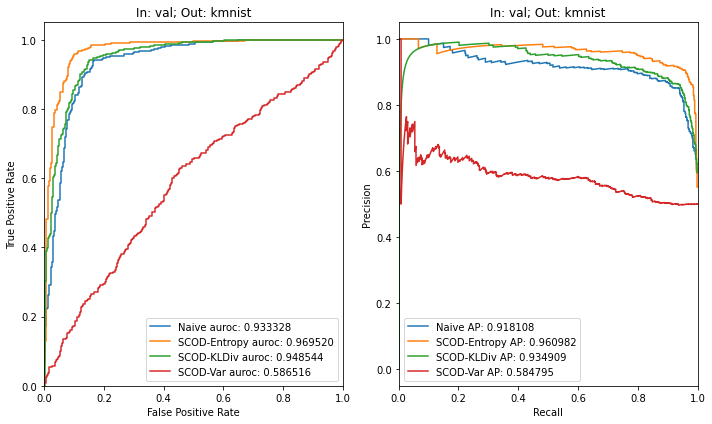

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

in_dist = 'val'
out_dists = ['fashion', 'emnist', 'kmnist']

for out_dist in out_dists:
    fig, axes = plt.subplots(1,2, figsize=[10,6])

    for result in results:
        label = result['name']
        in_uncs = result[in_dist]
        out_uncs = result[out_dist]

        y_true = np.concatenate([np.zeros(len(in_uncs)), np.ones(len(out_uncs))])
        preds = torch.cat([in_uncs, out_uncs])
        fpr, tpr, thresh = roc_curve(y_true, preds)
        auroc = roc_auc_score(y_true, preds)

        precision, recall, _ = precision_recall_curve(y_true, preds)
        avg_prec = average_precision_score(y_true, preds)

        axes[0].plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))
        axes[1].plot(recall, precision, label=(label + " AP: %03f" % avg_prec))

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].set_title(f"In: {in_dist}; Out: {out_dist}")
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    axes[1].set_title(f"In: {in_dist}; Out: {out_dist}")
    plt.tight_layout()
    plt.show()